# Práctica computacional de Física Teórica 3: Modelo de Ising 2D

_Por Fernando Del Rio, Augusto Chantada y Gabriel Goren._

## Ejercicio 1: Tiempo de equilibración

Se nos pide estudiar cuánto tiempo (iteraciones) es necesario para termalizar una cadena de Markov-Montecarlo para el modelo de Ising bidimensional a una cierta temperatura, observando cómo evolucionan la magnetización y la energía del sistema, y ver si esto depende o no de la temperatura y del tamaño de la red.

A priori, es esperable que el tiempo de termalización sí dependa del tamaño de la red, dado que si la red tiene $N$ sitios, entonces se necesitan por lo menos $N$ iteraciones para modificar una vez cada spin y "olvidar" el estado inicial aleatorio. Además, también es esperable que dependa de la temperatura: a temperatuas más bajas, la probabilidad de transición hacia estados de mayor energía es más baja y eso en principio haría que la cadena tarde más tiempo en salir de mínimos locales (como veremos, a temperaturas muy bajas hay ciertos mínimos locales de los que la cadena no puede salir en una cantidad razonable de iteraciones).

Por otro lado, también sabemos que cerca del punto crítico deberíamos esperar mayores fluctuaciones térmicas, con lo cual podría ser que sea necesario un mayor tiempo de termalización.

En todo lo que sigue, asumiremos siempre $k_b = J = 1$. De esta forma, sabemos que la temperatura crítica es $T_c = \frac{2}{\ln(\sqrt(2)+1)} \simeq 2.26919$ independientemente del tamaño de la red.

Comenzamos importando las librerías y definiendo las funciones que vamos a usar para este punto:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calcMagnet(S):

    M = np.sum(S)

    return M

def vecinos(S,i,j,numfilas,numcols):
    """Implementación de las condiciones de contorno periódicas. Esta función
    es llamada tanto por calcEnergia() como por ising2Dpaso()."""
    if i == (numfilas-1):
        if j == (numcols-1):
            #Estamos en la esquina inferior derecha
            res = [S[i, j-1], S[0, j], S[i, 0], S[i-1, j]]
        else:
            #Estamos en el borde inferior sin la esquina derecha
            res = [S[i,j-1], S[0, j], S[i, j+1], S[i-1,j]]
    else:
        if j==(numcols-1):
            #Estamos en el borde derecho sin la esquina inferior
            res = [S[i,j-1], S[i+1, j], S[i, 0], S[i-1,j]]
        else:
            #Estamos en cualquier otro lado
            res = [S[i,j-1], S[i+1, j], S[i, j+1], S[i-1,j]]
    return res

def calcEnergia(S):
    (numfilas,numcols) = np.shape(S)
    E = 0
    for i in range(numfilas):
        for j in range (numcols):
            E = E + -1 * S[i,j] * sum(vecinos(S,i,j,numfilas,numcols))
    # Como contamos cada interacción dos veces, el resultado correcto se obtiene
    # dividiendo por dos:
    return E/2

def ising2Dpaso(S, beta):
    (numfilas, numcols) = np.shape(S)
    #Selección aleatoria del sitio a modificar
    ax = int(np.floor( (np.random.rand())*numfilas ))
    ay = int(np.floor( (np.random.rand())*numcols ))

    spin_nuevo = -1 * S[ax,ay]

    dE = -1 * (spin_nuevo - S[ax,ay]) * sum(vecinos(S,ax,ay,numfilas,numcols))
    dM = (spin_nuevo - S[ax,ay])
    
    # Determinación de la nueva matriz
    if dE <= 0:
        S[ax,ay] = spin_nuevo
        return S, dE, dM
    elif np.random.rand() <= np.exp(-1 * beta * dE):
        S[ax,ay] = spin_nuevo
        return S, dE, dM
    else:
        return S, 0, 0

Empezamos con una red de 16 \* 16 = 256 sitios. Veamos qué pasa para distintas temperaturas en el rango 1 a 10, empezando con un barrido grueso con salto unitario y sin omitir ninguna iteración inicial:

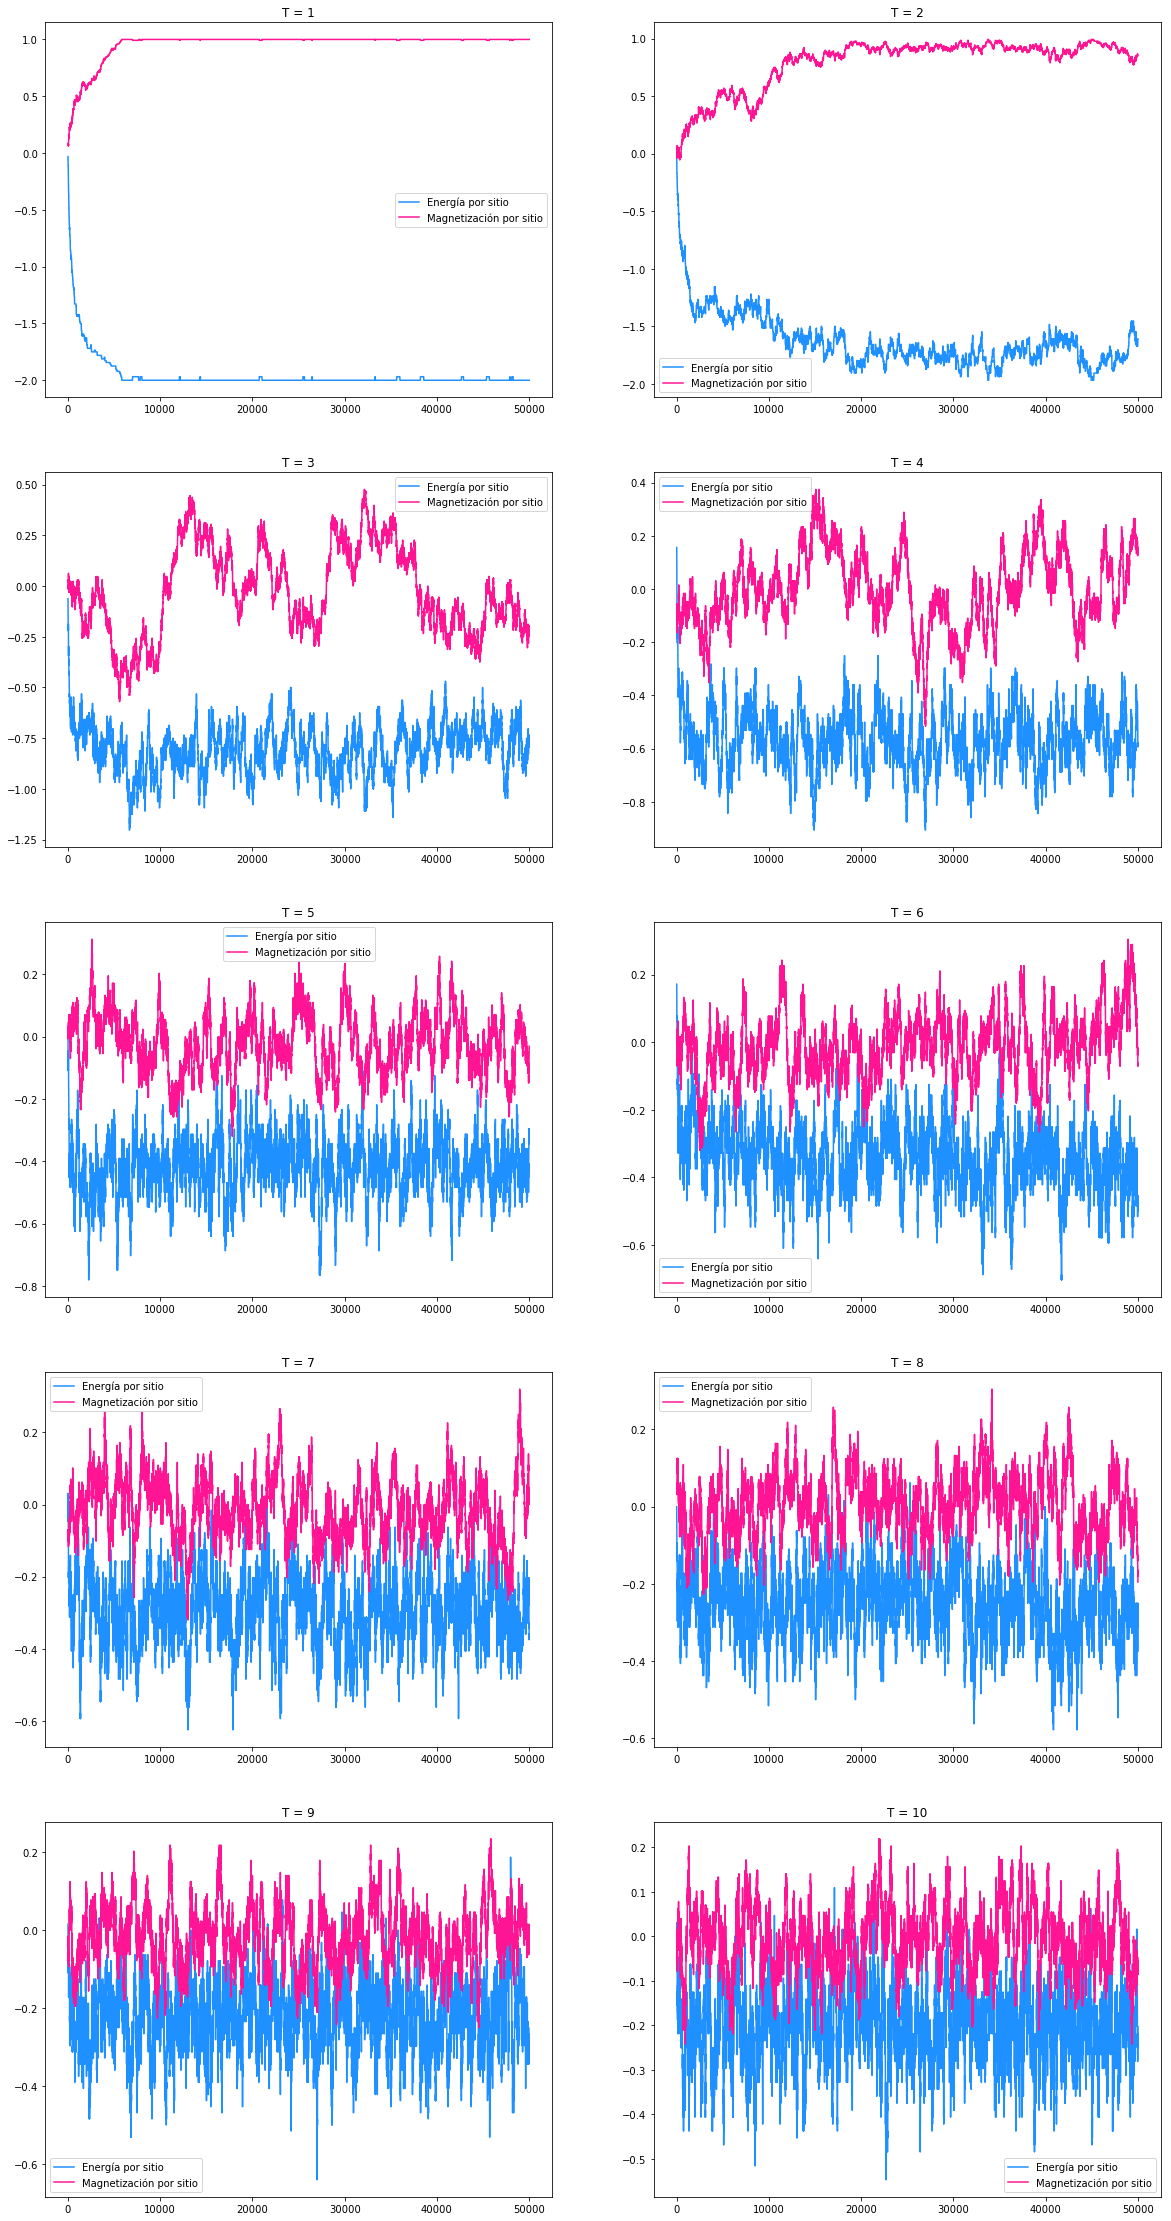

In [34]:
L = 16
N = L**2

npre = 0
npasos = 50000
energia = np.zeros(npasos)
magnet = np.zeros(npasos)               

# Para graficar:
fig = plt.figure(figsize=(20,40))
axes = {}

# Rango de temperaturas:
los_T = range(1, 11)
                 
for i, T in enumerate(los_T):
    #Inicialización aleatoria de la cadena:
    S = 2*(np.random.rand(L,L)>0.5) -1
    beta=1/T
    
    #for n in range(npre):
    #        S, _, _ = ising2Dpaso(S,beta) #No lo usamos ahora

    energia[0] = calcEnergia(S)
    magnet[0] = calcMagnet(S)
    
    for n in range(npasos-1):
        S, dE, dM = ising2Dpaso(S,beta);
        energia[n+1] = energia[n] + dE;
        magnet[n+1] = magnet[n] + dM;
    
    #Normalizamos para facilidad de análisis:
    energia = energia / N
    magnet  = magnet  / N
                 
    axes[i]= fig.add_subplot(5, 2, i+1) #El número de filas y columnas hay que ponerlo a mano
    axes[i].plot(energia, color='dodgerblue', label='Energía por sitio')
    axes[i].plot(magnet, color='deeppink', label='Magnetización por sitio')
    axes[i].set_title('T = %s' % T)
    axes[i].legend()

Corriendo este código varias veces, vemos que para $T=1$ el tiempo de termalización es bastante variable, yendo de menos de 5000 hasta casi 20 000 iteraciones, dependiendo de la realización. Para $T=2$, las cadenas termalizan luego de entre 10 000 y 30 000 iteraciones. Para temperaturas mayores, la termalización es mucho más rápida: se verificó aumentando `npasos` hasta 1 000 000 que el comportamiento de las cadenas en estos casos no cambia respecto del que presentan alrededor de la iteración 5000. Además se observa que aumentan las fluctuaciones al aumentar la temperatura, lo cual es esperable ya que la varianza de la energía es proporcional a la misma.

Probemos ahora que pasa para temperaturas más cercanas a la crítica:

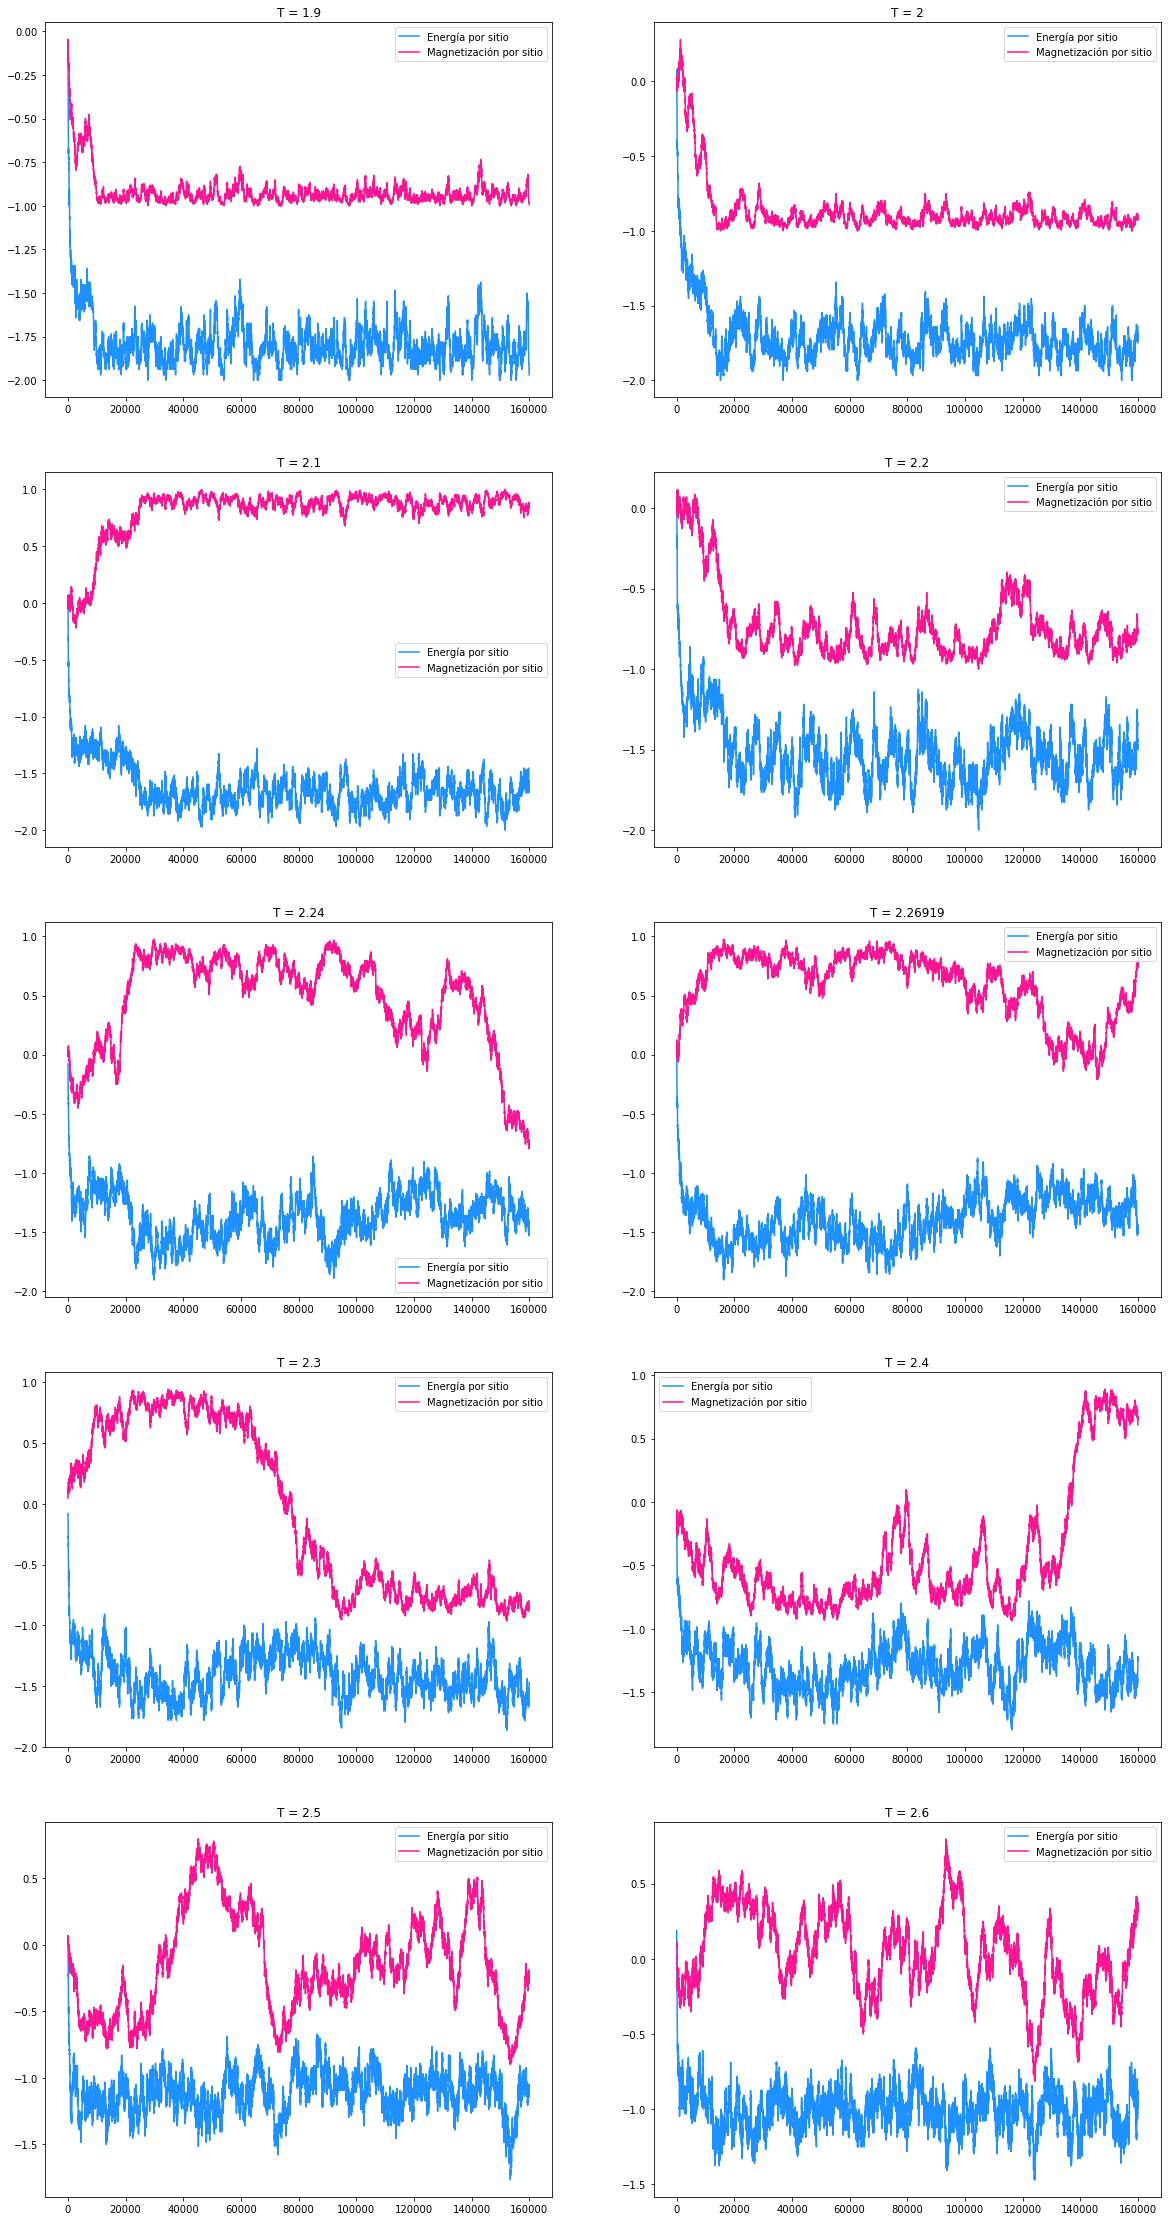

In [64]:
npre = 0
npasos = 160000
energia = np.zeros(npasos)
magnet = np.zeros(npasos)                
# Rango de temperaturas:
los_T = [1.9, 2, 2.1, 2.2, 2.24, 2.26919, 2.3, 2.4, 2.5, 2.6]

# Para graficar:
fig = plt.figure(figsize=(20,40))
axes = {}

for i, T in enumerate(los_T):
    #Inicialización aleatoria de la cadena:
    S = 2*(np.random.rand(L,L)>0.5) -1
    beta=1/T
    
    #for n in range(npre):
    #        S, _, _ = ising2Dpaso(S,beta) #No lo usamos ahora

    energia[0] = calcEnergia(S)
    magnet[0] = calcMagnet(S)
    
    for n in range(npasos-1):
        S, dE, dM = ising2Dpaso(S,beta);
        energia[n+1] = energia[n] + dE;
        magnet[n+1] = magnet[n] + dM;
    
    #Normalizamos para facilidad de análisis:
    energia = energia / N
    magnet  = magnet  / N
                 
    axes[i]= fig.add_subplot(5, 2, i+1) #El número de filas y columnas hay que ponerlo a mano
    axes[i].plot(energia, color='dodgerblue', label='Energía por sitio')
    axes[i].plot(magnet, color='deeppink', label='Magnetización por sitio')
    axes[i].set_title('T = %s' % T)
    axes[i].legend()

Se observa, corriendo este código varias veces, que para las temperaturas entre 2.2 y 2.6 el tiempo de termalización puede variar bastante y extenderse mucho maś allá de las 20 000 iteraciones. Además a veces se observan fluctuaciones muy grandes y que duran una gran cantidad de iteraciones.

Por último, veamos que pasa a temperaturas muy chicas:

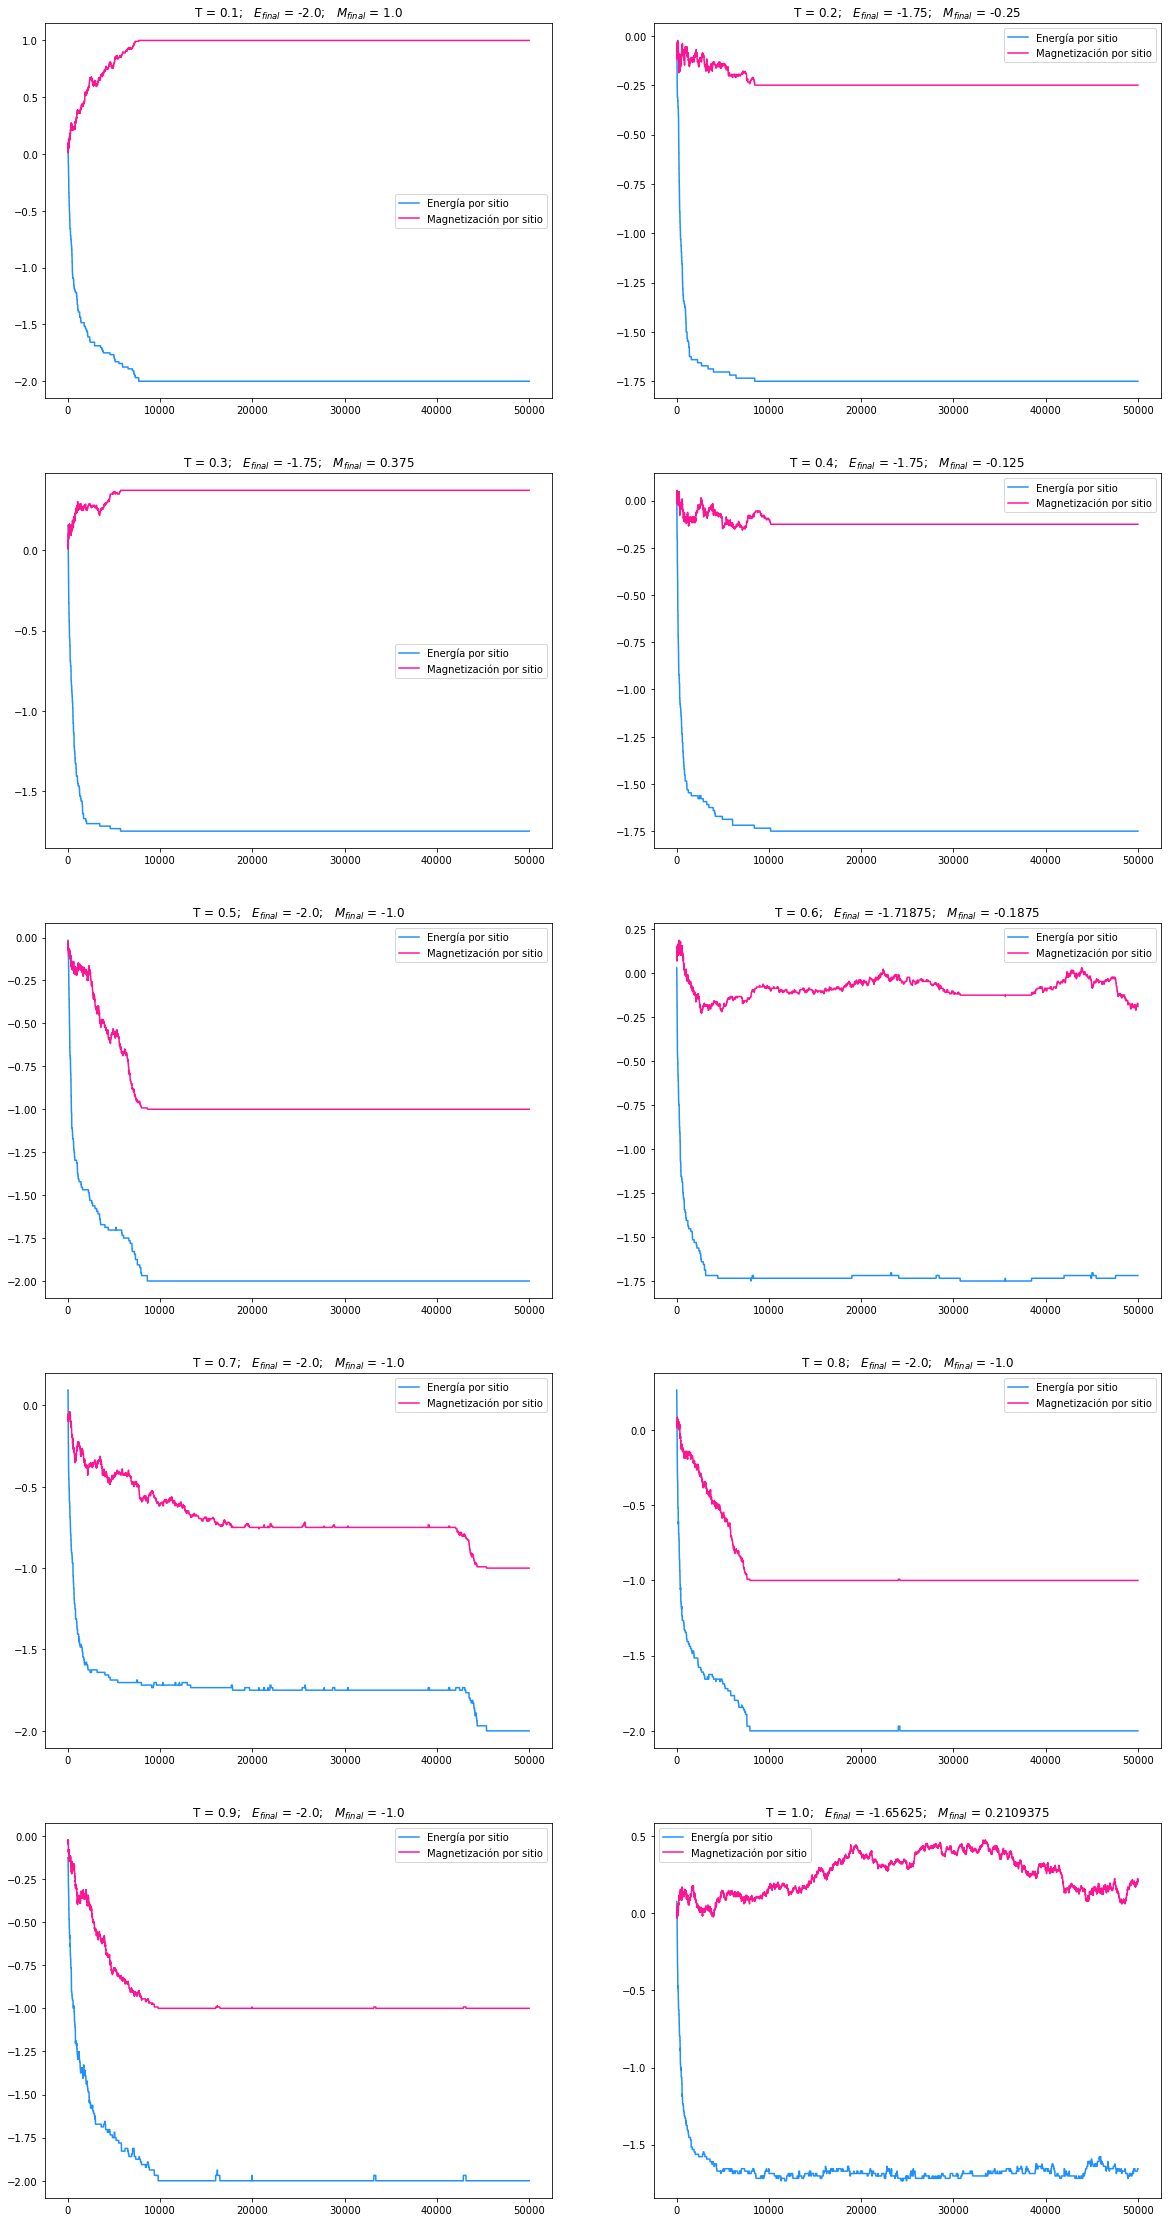

In [90]:
np.random.seed(6) # Para reproducibilidad

npre = 0
npasos = 50000
energia = np.zeros(npasos)
magnet = np.zeros(npasos)                
# Rango de temperaturas:
los_T = np.linspace(0.1, 1, 10)

# Para graficar:
fig = plt.figure(figsize=(20,40))
axes = {}

# Para la visualización de algunas matrices
matr = {}
ener = {}
magn = {}

for i, T in enumerate(los_T):
    #Inicialización aleatoria de la cadena:
    S = 2*(np.random.rand(L,L)>0.5) -1
    beta=1/T
    
    #for n in range(npre):
    #        S, _, _ = ising2Dpaso(S,beta) #No lo usamos ahora

    energia[0] = calcEnergia(S)
    magnet[0] = calcMagnet(S)
    
    for n in range(npasos-1):
        S, dE, dM = ising2Dpaso(S,beta);
        energia[n+1] = energia[n] + dE;
        magnet[n+1] = magnet[n] + dM;
    
    #Normalizamos para facilidad de análisis:
    energia = energia / N
    magnet  = magnet  / N
                 
    axes[i]= fig.add_subplot(5, 2, i+1) #El número de filas y columnas hay que ponerlo a mano
    axes[i].plot(energia, color='dodgerblue', label='Energía por sitio')
    axes[i].plot(magnet, color='deeppink', label='Magnetización por sitio')
    axes[i].set_title('T = %s;   $E_{final}$ = %s;   $M_{final}$ = %s' % (T, energia[npasos-1], magnet[npasos-1]))
    axes[i].legend()
    
    # Nos quedamos con las matrices finales para mostrar:
    matr[i] = S
    ener[i] = energia[npasos-1]
    magn[i] = magnet[npasos-1]

Se puede observar que no siempre el sistema se queda en su estado de energía mínima (todos apuntando para el mismo lado, magnetización por sitio igual a $\pm 1$, energía por sitio igual a $-2$), sino que a veces el estado "final" es uno con magnetización y energía menores en módulo a sus valores mínimos. Además estos valores están bien definidos, y no pueden ser cualquier cosa. Esto se debe a la existencia de mínimos locales de los cuales el sistema no logra salir en un lapso de tiempo razonable debido a que la probabilidad de hacerlo es muy baja (por ser baja la temperatura). Estas configuraciones de mínimo local consisten en dos dominios dispuestos en forma de bandas paralelas, con dos "domain walls" entre ellos. En estos casos, la inversión de cualquier spin individual genera un estado de mayor energía, y es en este sentido que el estado es un mínimo local. Como se ve usando la semilla 6 de números pseudoaleatorios de numpy (mediante el llamado `np.random.seed(6)`), algunas posibilidades son las siguientes:

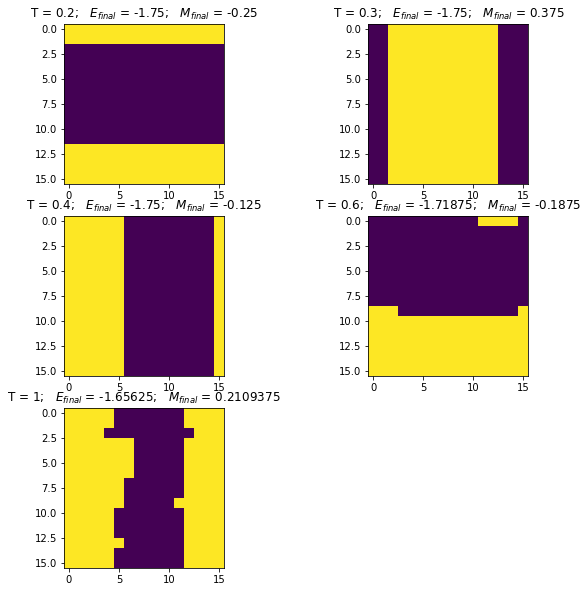

In [91]:
fig = plt.figure(figsize=(10,10))
axes = {}
12359
for i, j, T in zip([0,1,2,3,4], [1, 2, 3, 5, 9], [0.2, 0.3, 0.4, 0.6, 1]):
    axes[i]= fig.add_subplot(3, 2, i+1) #El número de filas y columnas hay que ponerlo a mano
    axes[i].imshow(matr[j])
    axes[i].set_title('T = %s;   $E_{final}$ = %s;   $M_{final}$ = %s' % (T, ener[j], magn[j]))